In [16]:
import numpy as np
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
#import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
#to predictive A
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

## Prophet으로 시계열 예측
- prophet : 시계열 데이터를 분석할 수 있는 패키지. facebook에서 만들었다.

In [17]:
df=pd.read_csv('sales_data.csv',encoding='unicode_escape')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


# Prophet
- 변수가 필요 없다. 실제 예측할 값과 시계열 데이터만 있으면 예측 가능
- 시계열과 예측값을 만드는데 특정 칼럼으로 만들어야 한다.
- 시계열 데이터 컬럼 ds 예측값은 y로 설정

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [19]:
# InvoiceDate 칼럼을 datetime 형식으로
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# 간단한 전처리 진행

In [21]:
df_1 = df.copy()

# 주문 데이터의 수량이 -인 경우 존재 => 반품
# -값은 날리고 +만 분석 진행
df_1=df_1[df_1.Quantity>0]
df_1=df_1[df_1.UnitPrice>0]

In [22]:
# ttp가 실제로 예측할 변수
df_1['ttp']= df_1['Quantity'] * df_1['UnitPrice']
df_1

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ttp
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [23]:
df_psp = df_1[['InvoiceDate','ttp']]
# InvoiceDate를 ds로, ttp를 y로 설정!
df_psp.rename(columns = {'InvoiceDate':'ds','ttp':'y'}, inplace = True)

In [24]:
df_psp

,ds,y
0,2010-12-01 08:26:00,15.30
1,2010-12-01 08:26:00,20.34
2,2010-12-01 08:26:00,22.00
3,2010-12-01 08:26:00,20.34
4,2010-12-01 08:26:00,20.34
...,...,...
541904,2011-12-09 12:50:00,10.20
541905,2011-12-09 12:50:00,12.60
541906,2011-12-09 12:50:00,16.60
541907,2011-12-09 12:50:00,16.60


## 일별 주문량으로 정리하여 데이터프레임 만들자

In [25]:
df_psp = df_psp.set_index("ds")
df_f = df_psp.resample('D')['y'].sum()

In [26]:
df_f = df_f.to_frame()
df_f

,y
ds,
2010-12-01,58960.79
2010-12-02,47748.38
2010-12-03,46943.71
2010-12-04,0.00
2010-12-05,31774.95
...,...
2011-12-05,88741.96
2011-12-06,56713.21
2011-12-07,75439.16


<Axes: xlabel='ds'>

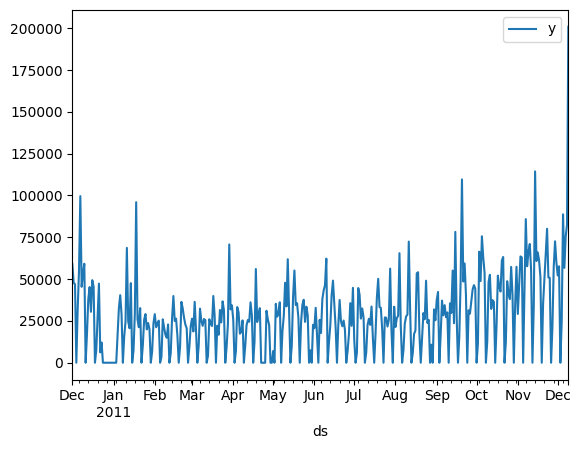

In [27]:
df_f.plot()

- 2010년 12월 ~ 2011년 12월까지 점점 우상향 경향
- 자기가 알아서 계절성 잡아주고, 추세 트렌드 확인 후 예측해준다


In [28]:
df_f.reset_index(inplace = True) # 인덱스를 다시 풀어서 두 컬럼으로 만든다
df_f

,ds,y
0,2010-12-01,58960.79
1,2010-12-02,47748.38
2,2010-12-03,46943.71
3,2010-12-04,0.00
4,2010-12-05,31774.95
...,...,...
369,2011-12-05,88741.96
370,2011-12-06,56713.21
371,2011-12-07,75439.16
372,2011-12-08,82495.00


In [29]:
#train, test set 나누기
# train 데이터를 가지고 미래 30일을 예측하여 test 데이터와 비교해서 실제 값이 어떤지 확인한다

train=df_f[:334]
test = df_f[334:] #시계열 데이터는 shuffle 하지 않는다.

In [30]:
train

,ds,y
0,2010-12-01,58960.79
1,2010-12-02,47748.38
2,2010-12-03,46943.71
3,2010-12-04,0.00
4,2010-12-05,31774.95
...,...,...
329,2011-10-26,38059.43
330,2011-10-27,57291.72
331,2011-10-28,40565.70
332,2011-10-29,0.00


In [31]:
prophet= Prophet(daily_seasonality = True, growth  = 'linear')
prophet.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy83cvm_g/wfasqyiv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy83cvm_g/tz2ph3ur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9700', 'data', 'file=/tmp/tmpy83cvm_g/wfasqyiv.json', 'init=/tmp/tmpy83cvm_g/tz2ph3ur.json', 'output', 'file=/tmp/tmpy83cvm_g/prophet_model8m3cfzpw/prophet_model-20230702082353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:23:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:23:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [32]:
# 이후의 기간 얼마나 예측해서 출력할 것 인가
future= prophet.make_future_dataframe(periods= 40)
forecast = prophet.predict(future)

In [33]:
ph_yhat = forecast[['ds','yhat']][334:] # 실제 예측한 값
ph_yhat

,ds,yhat
334,2011-10-31,38042.252834
335,2011-11-01,48973.131519
336,2011-11-02,40296.462846
337,2011-11-03,47928.738202
338,2011-11-04,38397.732011
339,2011-11-05,10115.463038
340,2011-11-06,23827.421392
341,2011-11-07,38610.651013
342,2011-11-08,49541.529697
343,2011-11-09,40864.861024


In [34]:
test

,ds,y
334,2011-10-31,57369.15
335,2011-11-01,29155.15
336,2011-11-02,45888.34
337,2011-11-03,63561.49
338,2011-11-04,62977.36
339,2011-11-05,0.00
340,2011-11-06,42946.34
341,2011-11-07,85881.81
342,2011-11-08,57700.24
343,2011-11-09,66127.57


          ds          yhat    yhat_lower    yhat_upper
0 2010-12-01  29654.570583  12903.387236  46286.308398
1 2010-12-02  37159.751346  20641.148937  54419.794089
2 2010-12-03  27501.650563   9772.439964  44332.779838
3 2010-12-04   -907.713003 -17944.060785  16849.401437
4 2010-12-05  12677.150758  -4498.541965  28901.664165


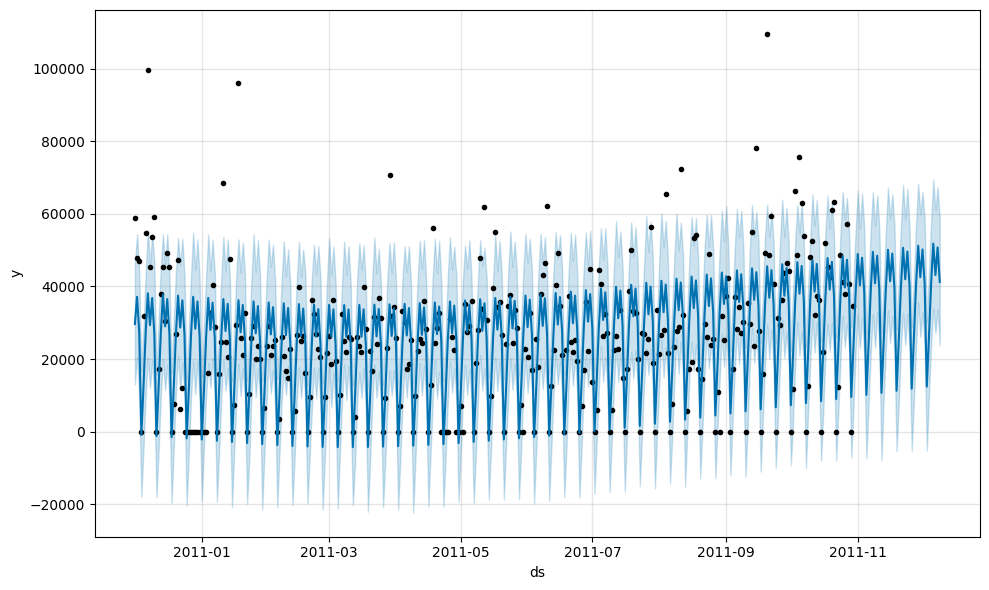

In [35]:
#forecast 시각화
print(forecast[['ds','yhat','yhat_lower','yhat_upper']].head())
#plot을 통한 시각화
prophet.plot(forecast)
plt.show()

In [36]:
test

,ds,y
334,2011-10-31,57369.15
335,2011-11-01,29155.15
336,2011-11-02,45888.34
337,2011-11-03,63561.49
338,2011-11-04,62977.36
339,2011-11-05,0.00
340,2011-11-06,42946.34
341,2011-11-07,85881.81
342,2011-11-08,57700.24
343,2011-11-09,66127.57


In [37]:
ph_yhat

,ds,yhat
334,2011-10-31,38042.252834
335,2011-11-01,48973.131519
336,2011-11-02,40296.462846
337,2011-11-03,47928.738202
338,2011-11-04,38397.732011
339,2011-11-05,10115.463038
340,2011-11-06,23827.421392
341,2011-11-07,38610.651013
342,2011-11-08,49541.529697
343,2011-11-09,40864.861024


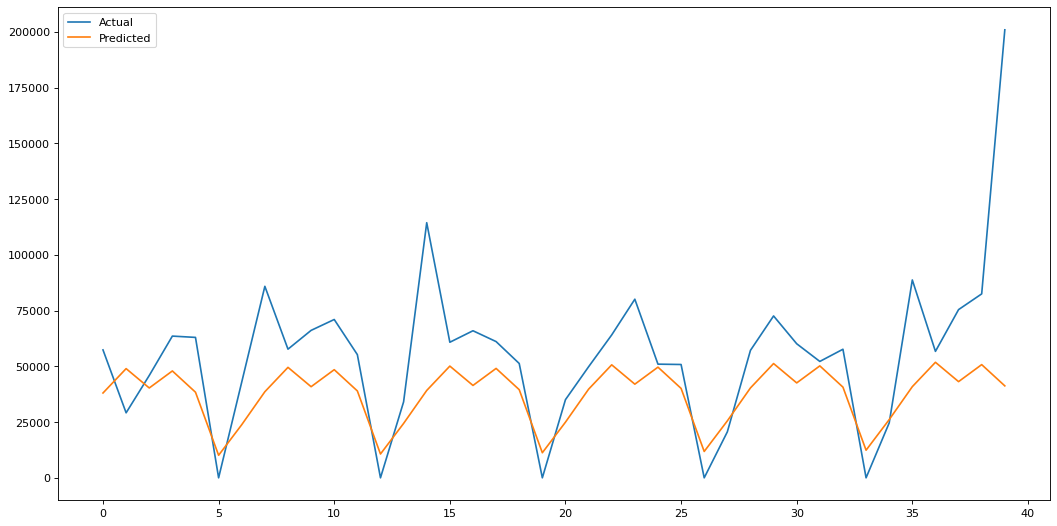

In [38]:
# plot 예측값과 실제 값을 비교해서 트렌드를 보자!
from matplotlib.pyplot import figure
figure(figsize=(16,8), dpi=80)

plt.plot(test['y'].values, label='Actual')
plt.plot(ph_yhat['yhat'].values, label='Predicted')
plt.legend()
plt.show()

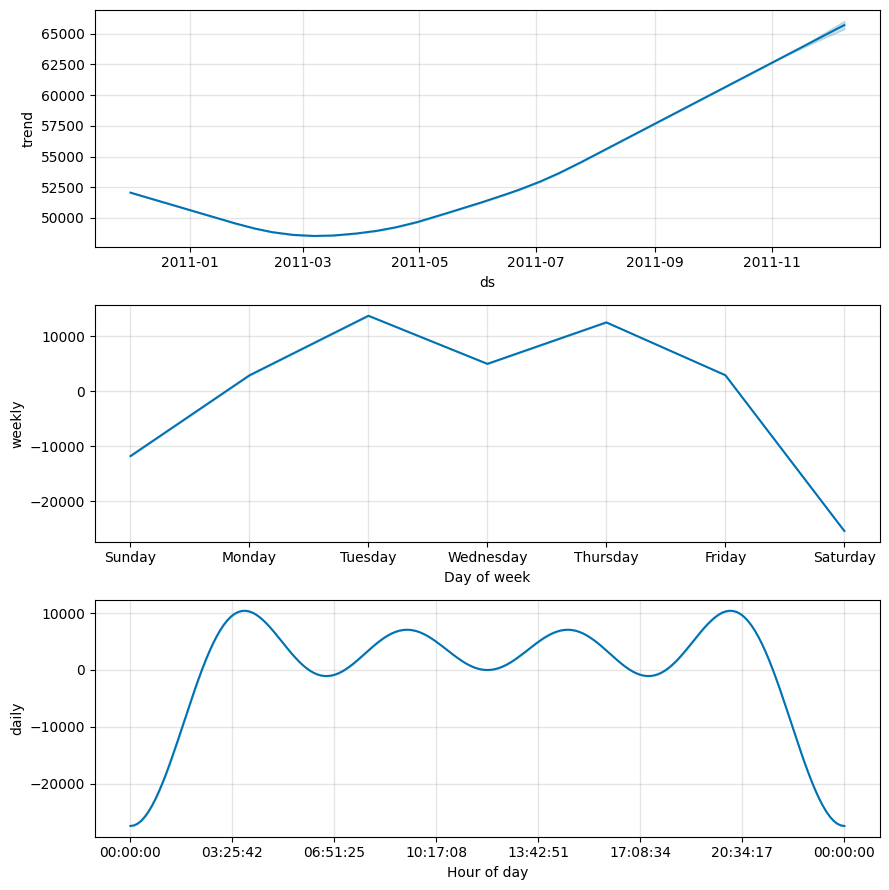

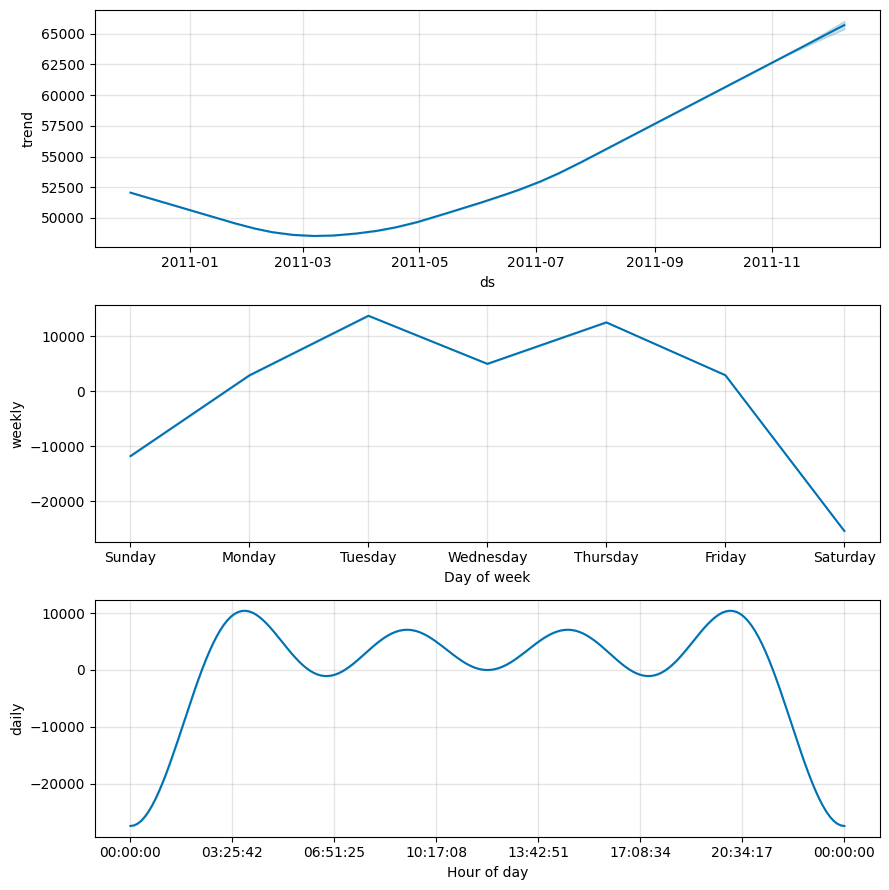

In [39]:
# 요일에 대한 트렌드 확인하기
prophet.plot_components(forecast)